# Problem 1: Data Acquisition and Analysis

In [227]:
from sodapy import Socrata
import pandas as pd
import geopandas
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
import cenpy as c
import numpy as np
import seaborn
from datetime import datetime

#### Download reported crime data from the Chicago open data portal for 2017 and 2018.

In [228]:
client = Socrata("data.cityofchicago.org", '6sr95dE6LHGM6Ga2Z2kOU2OfL')
results = client.get("6zsd-86xi", limit=600000, where='year == 2017 OR year == 2018')
crime_df = geopandas.GeoDataFrame(results)

#### Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

In [229]:
crime_df['date'] = pd.to_datetime(crime_df.date)
crime_df['month_year'] = crime_df.apply(lambda x: x['date'].strftime('%Y-%m'), axis=1)
month_trend = pd.DataFrame(crime_df.groupby(by='month_year').size(), columns=['crime_count'])

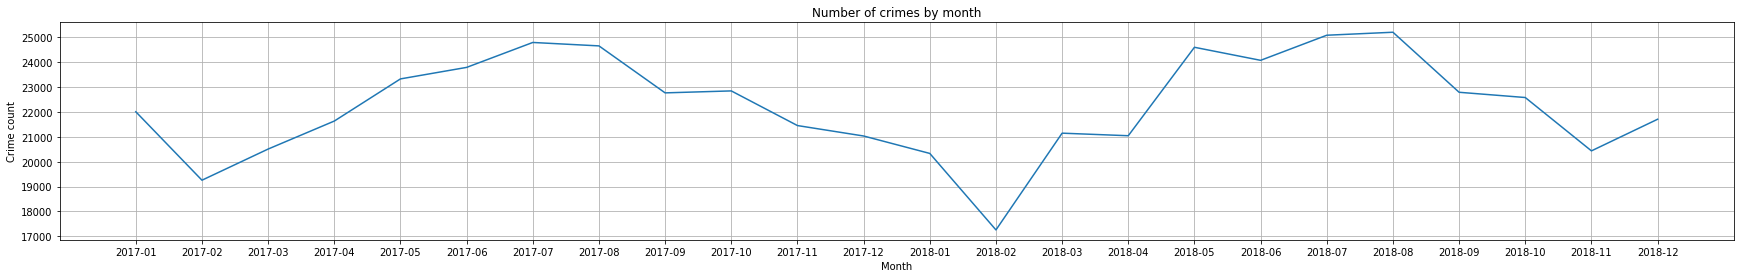

In [230]:
fig, ax = plt.subplots()
ax.plot(month_trend.index, month_trend.crime_count)
ax.set(xlabel='Month', ylabel='Crime count',
       title='Number of crimes by month')
ax.grid()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.show()

Number of crimes tends to dip in the winter months and increase in the summer months.

In [231]:
community_area_count = pd.DataFrame(crime_df.groupby(
    by=['community_area']).size(), columns=['crime_count'])
community_area_count['percent'] = community_area_count.apply(
    lambda x: x['crime_count'] / community_area_count.crime_count.sum(), axis=1)
community_area_count.sort_values(by='crime_count', ascending=False).head(n=10)

,crime_count,percent
community_area,,
25,30428,0.056942
8,25367,0.047471
32,21480,0.040197
28,18448,0.034523
29,18376,0.034388
43,17325,0.032421
23,16095,0.030119
24,15625,0.029240
71,14897,0.027878


Above are the top 10 community areas with the most crimes from 2017-2018. Out of 77 community areas, community area 25 (Austin) accounts for the most crimes, about 5.6%.

In [232]:
top_two = crime_df.loc[(crime_df.community_area == '25') | (crime_df.community_area == '8')].groupby(
    ['primary_type', 'community_area']).size().unstack()
top_two.columns = ['Near North', 'Austin']
top_two['Near North Pct'] = top_two['Near North'] / top_two['Near North'].sum()
top_two['Austin Pct'] = top_two['Austin'] / top_two['Austin'].sum()
top_two

,Near North,Austin,Near North Pct,Austin Pct
primary_type,,,,
ARSON,61.0,10.0,0.002005,0.000394
ASSAULT,2422.0,1013.0,0.079598,0.039934
BATTERY,6722.0,2957.0,0.220915,0.116569
BURGLARY,1018.0,454.0,0.033456,0.017897
CONCEALED CARRY LICENSE VIOLATION,7.0,2.0,0.000230,0.000079
CRIM SEXUAL ASSAULT,211.0,205.0,0.006934,0.008081
CRIMINAL DAMAGE,3086.0,1245.0,0.101420,0.049080
CRIMINAL TRESPASS,577.0,711.0,0.018963,0.028029
DECEPTIVE PRACTICE,1536.0,3816.0,0.050480,0.150432


The top two community areas for crime are Austin (25) and Near North (8). There are significant differences in the types of crime that happen between these two community areas. For example, theft makes up 47% of crimes in Austin but only 15% in Near North. Battery makes up 22% of crimes in Near North and only 11% in Austin.

In [233]:
type_count = pd.DataFrame(crime_df.groupby(
    by=['primary_type']).size(), columns=['crime_count'])
type_count['percent'] = type_count.apply(
    lambda x: x['crime_count'] / type_count.crime_count.sum(), axis=1)
type_count.sort_values(by='crime_count', ascending=False)

,crime_count,percent
primary_type,,
THEFT,129428,0.242205
BATTERY,98995,0.185254
CRIMINAL DAMAGE,56848,0.106382
ASSAULT,39680,0.074255
DECEPTIVE PRACTICE,37764,0.070670
OTHER OFFENSE,34357,0.064294
BURGLARY,24730,0.046278
NARCOTICS,24646,0.046121
ROBBERY,21559,0.040344


The most common type of crime committed is theft, accounting for 24.2% of crimes from 2017-2018.

# Problem 2: Data Augmentation and APIs

#### All of the crime data you just analyzed have a block address and lat/long fields. The task now is to augment that data with American Community Survey data. For each crime report, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block or zipcode where the crime report came from. This could include information about demographics of the block or zipcode (race, income, family size, etc.).

In [234]:
census_tracts = client.get("74p9-q2aq")
tracts_df = geopandas.GeoDataFrame(census_tracts)

In [235]:
def convert_point(row):
    '''
    Given a row from a dataframe, takes the longitude and latitude columns
    and returns a shapely Point object.
    '''
    if pd.isnull(row['longitude']) or pd.isnull(row['latitude']):
        return None
    return Point(float(row['longitude']), float(row['latitude']))

In [236]:
def convert_polygon(row):
    '''
    Given a row from a dataframe, takes the 'the_geom' columns
    and returns a shapely Polygon or MultiPolygon object.
    '''
    coordinates_list = row['the_geom'].get('coordinates')
    polygon_list = []
    for coordinates in coordinates_list:
        while type(coordinates[0][0]) is list:
            coordinates = coordinates[0]
        polygon_list.append(Polygon(coordinates))
    return MultiPolygon(polygon_list)

In [237]:
crime_df['geometry'] = crime_df.apply(convert_point, axis=1)

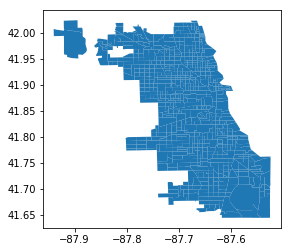

In [238]:
tracts_df['geometry'] = tracts_df.apply(convert_polygon, axis=1)
tracts_df.plot()

In [239]:
crime_tract_df = geopandas.sjoin(crime_df.loc[crime_df.geometry.notna()], tracts_df, how='left')

In [240]:
conn = c.base.Connection('ACSDT5Y2017')
cols = ["B19326_001E", "B03002_018E", "B03002_006E", "B03002_007E", "B03002_003E", "B03002_004E", "B03002_001E"]
census_df = conn.query(
    cols, geo_unit='tract', geo_filter={'state': '17', 'county': '031'}, apikey='cba0886fe60dfd507ca24cd3be4831bb1b3113ba')
census_df.rename(columns={"B19326_001E": "median_hhi",
             "B03002_018E": "hispanic_pop",
            "B03002_006E": "asian_pop",
            "B03002_007E": "nhpi_pop",
            "B03002_003E": "white_pop",
            "B03002_004E": "black_pop",
            "B03002_001E": "total_pop"}, inplace=True)

In [241]:
census_df['median_hhi'] = census_df.median_hhi.astype('int')
census_df['hispanic_pop'] = census_df.hispanic_pop.astype('int')
census_df['asian_pop'] = census_df.asian_pop.astype('int')
census_df['nhpi_pop'] = census_df.nhpi_pop.astype('int')
census_df['white_pop'] = census_df.white_pop.astype('int')
census_df['black_pop'] = census_df.black_pop.astype('int')
census_df['total_pop'] = census_df.total_pop.astype('int')
census_df.dtypes

median_hhi       int32
hispanic_pop     int32
asian_pop        int32
nhpi_pop         int32
white_pop        int32
black_pop        int32
total_pop        int32
state           object
county          object
tract           object
dtype: object

1. What types of blocks have reports of “Battery”?

In [242]:
def pop_normalize(field, row):
    '''
    Given a field name and a row, normalizes
    that field based on the total population.
    '''
    if row['total_pop'] > 0:
        return row[field] / row['total_pop']
    else:
        return float('NaN')

In [243]:
def pop_percent(population, row):
    '''
    Given a field name for a population,
    returns the percent of that population wrt
    the total population.
    '''
    if row['total_pop'] > 0:
        return row[population] / row['total_pop']
    else:
        return float('NaN')

In [244]:
def analyze_type(primary_type, df_name, df):
    '''
    Given a primary_type of a crime, creates and returns
    a dataframe pertaining to that crime with summary stats
    by census tract.
    '''
    df_name = pd.DataFrame(
        df.loc[df.primary_type == primary_type].groupby(by='tractce10').size(), columns=['crime_count'])
    df_name = df_name.merge(census_df, left_on='tractce10', right_on='tract')
    df_name['count_pop'] = df_name.apply(lambda x: pop_normalize('crime_count', x), axis=1)
    return df_name

In [245]:
def crime_scatter(df_name, field):
    '''
    Creates and returns a scatter plot using a
    given dataframe which shows the correlation between
    the count of crimes per population and a given field.
    '''
    fig, ax = plt.subplots()
    x = df_name.count_pop.loc[df_name[field] > 0]
    y = df_name[field].loc[df_name[field] > 0]
    ax.set(xlabel='Crimes/Population', ylabel=field,
           title=" ".join(["Crimes/Population and", field]))
    plt.scatter(x, y)
    plt.show()

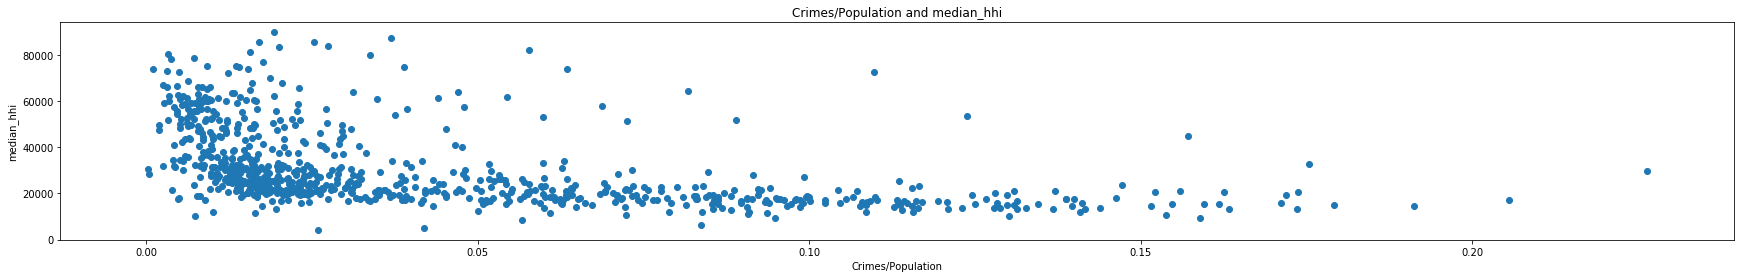

In [246]:
battery_tract = analyze_type('BATTERY', 'battery_tract', crime_tract_df)
crime_scatter(battery_tract, "median_hhi")

Census tracts with lower median household incomes tend to have higher incidences of Battery crimes per total population.

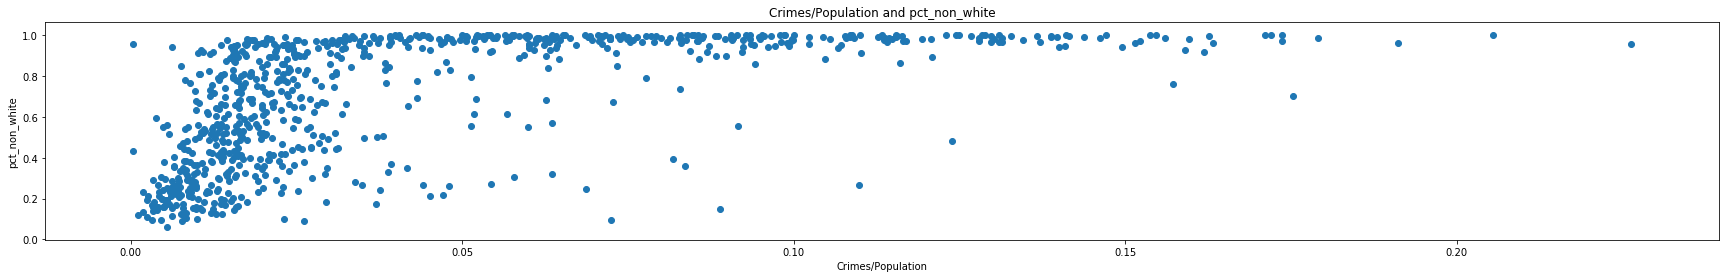

In [247]:
battery_tract['pct_non_white'] = battery_tract.apply(lambda x: 1 - (pop_percent('white_pop', x)), axis=1)
crime_scatter(battery_tract, 'pct_non_white')

Census tracts with higher non-white populations tend to have higher incidences of Battery crimes per total population.

2. What types of blocks get “Homicide”?

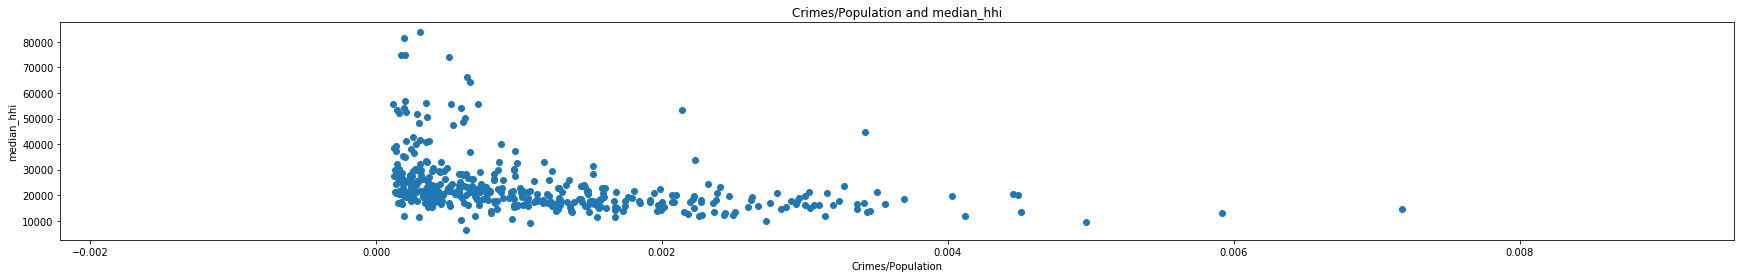

In [248]:
homicide_tract = analyze_type('HOMICIDE', 'homicide_tract', crime_tract_df)
crime_scatter(homicide_tract, "median_hhi")

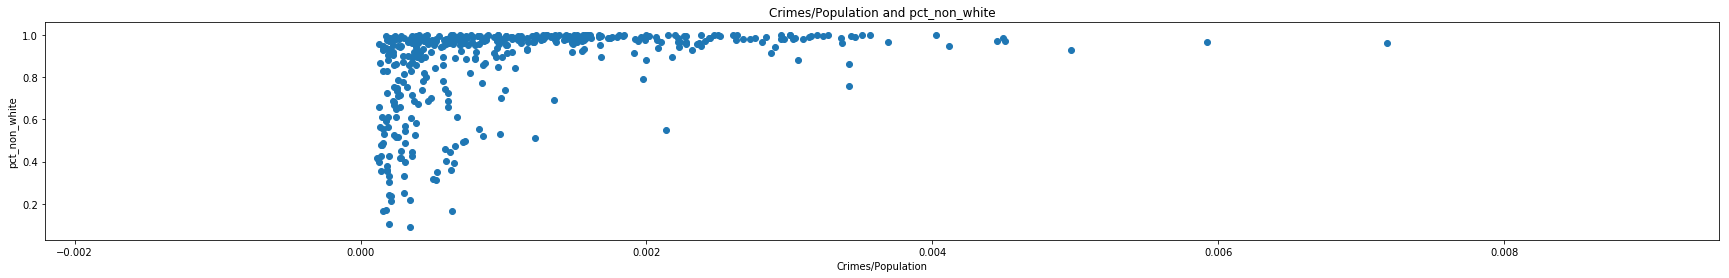

In [249]:
homicide_tract['pct_non_white'] = homicide_tract.apply(lambda x: 1 - (pop_percent('white_pop', x)), axis=1)
crime_scatter(homicide_tract, 'pct_non_white')

Homicide crimes similarly occur more in tracts with lower median household incomes and higher non-white populations.

3. Does that change over time in the data you collected?

In [250]:
battery_tract_2017 = analyze_type('BATTERY', 'battery_tract', crime_tract_df.loc[crime_tract_df.year == '2017'])
battery_tract_2018 = analyze_type('BATTERY', 'battery_tract', crime_tract_df.loc[crime_tract_df.year == '2018'])
homicide_tract_2017 = analyze_type('HOMICIDE', 'battery_tract', crime_tract_df.loc[crime_tract_df.year == '2017'])
homicide_tract_2018 = analyze_type('HOMICIDE', 'battery_tract', crime_tract_df.loc[crime_tract_df.year == '2018'])

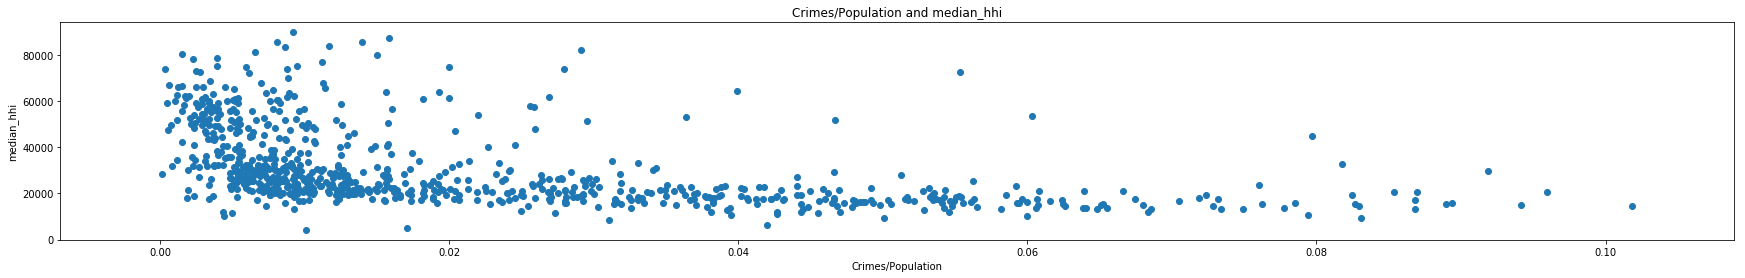

In [251]:
crime_scatter(battery_tract_2017, "median_hhi")

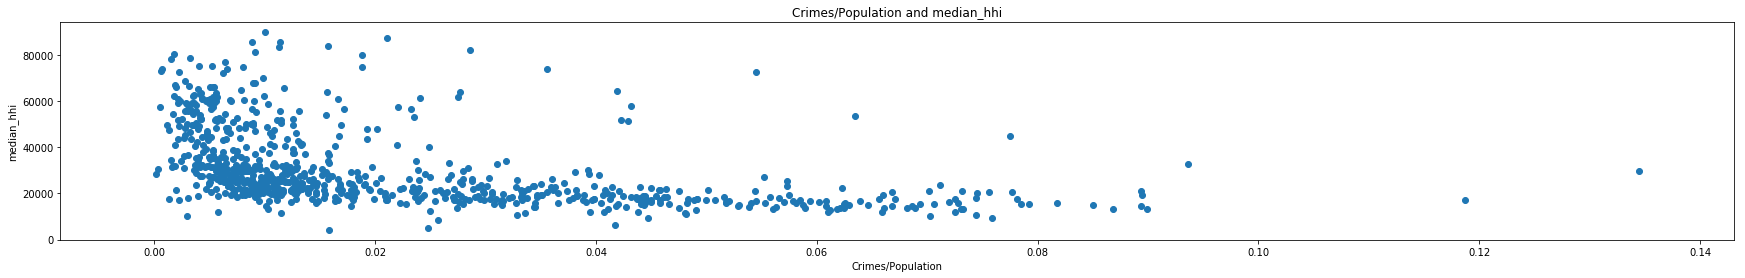

In [252]:
crime_scatter(battery_tract_2018, "median_hhi")

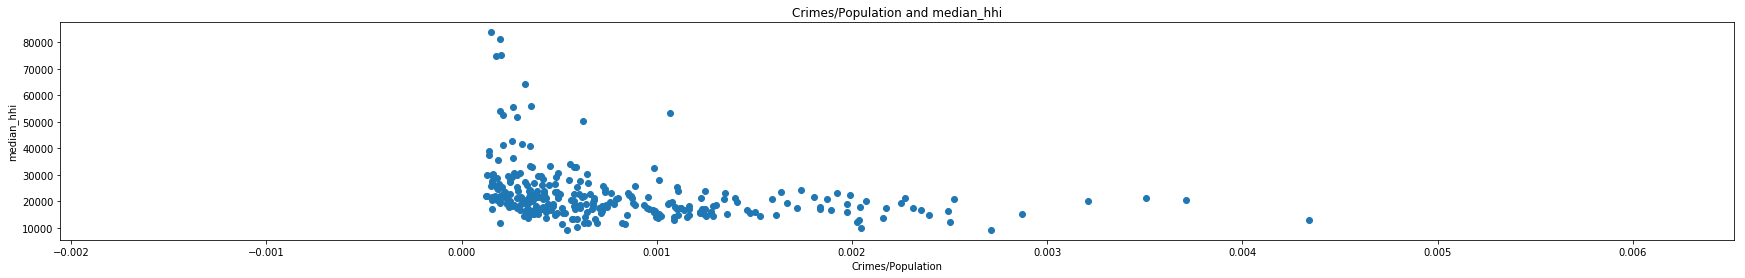

In [253]:
crime_scatter(homicide_tract_2017, "median_hhi")

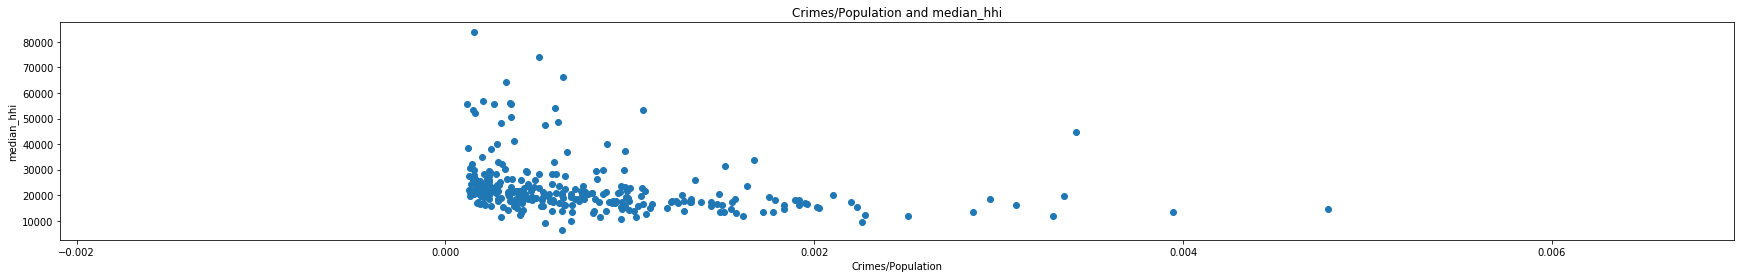

In [254]:
crime_scatter(homicide_tract_2018, "median_hhi")

When broken down between 2017 and 2018, these trends have remained relatively stable.

4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

In [255]:
crimes_per_tract = pd.DataFrame(crime_tract_df.groupby(['tractce10', 'primary_type']).size(), columns=['crime_count'])
crimes_per_tract = crimes_per_tract.unstack()
crimes_per_tract.columns = crimes_per_tract.columns.droplevel()
crimes_per_tract = crimes_per_tract[['DECEPTIVE PRACTICE', 'SEX OFFENSE']]
crimes_per_tract.rename(columns={'DECEPTIVE PRACTICE': 'Deceptive Practice Count',
                                'SEX OFFENSE': 'Sex Offense Count'}, inplace=True)

In [256]:
pct_per_tract = pd.DataFrame(
    crime_tract_df.groupby(['tractce10', 'primary_type']).size()/crime_tract_df.groupby('tractce10').size()*100,
    columns=['pct_crime'])
pct_per_tract = pct_per_tract.unstack()
pct_per_tract.columns = pct_per_tract.columns.droplevel()
pct_per_tract = pct_per_tract[['DECEPTIVE PRACTICE', 'SEX OFFENSE']]
pct_per_tract.rename(columns={'DECEPTIVE PRACTICE': 'Deceptive Practice Pct',
                                'SEX OFFENSE': 'Sex Offense Pct'}, inplace=True)

In [257]:
counts_pcts = pct_per_tract.merge(crimes_per_tract, on='tractce10')
counts_pcts_census = counts_pcts.merge(census_df, how='left', left_on='tractce10', right_on='tract')
counts_pcts_census['pct_white'] = counts_pcts_census.apply(lambda x: pop_percent('white_pop', x), axis=1)

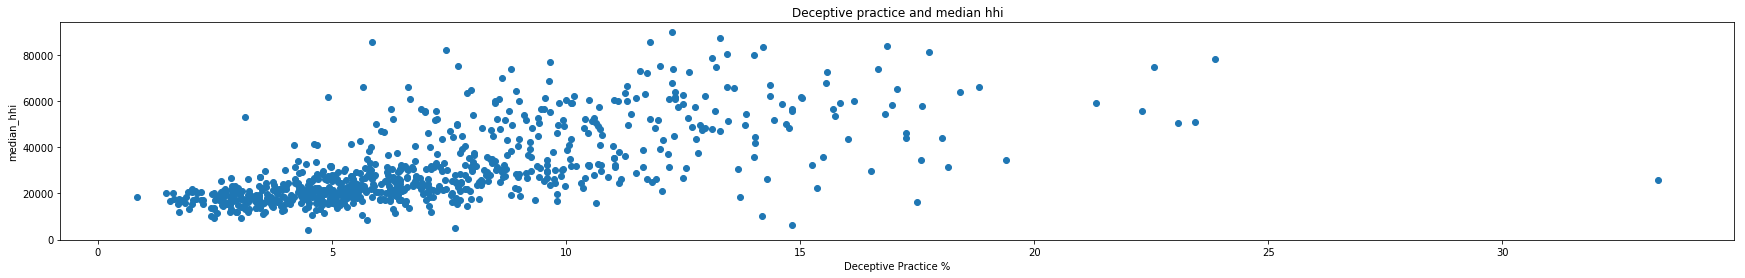

In [258]:
fig, ax = plt.subplots()
x = counts_pcts_census['Deceptive Practice Pct'].loc[counts_pcts_census.median_hhi > 0]
y = counts_pcts_census['median_hhi'].loc[counts_pcts_census.median_hhi > 0]
ax.set(xlabel='Deceptive Practice %', ylabel='median_hhi',
       title="Deceptive practice and median hhi")
plt.scatter(x, y)
plt.show()

Tracts with higher median household incomes tend to have deceptive practice as a higher percentage of their total crimes.

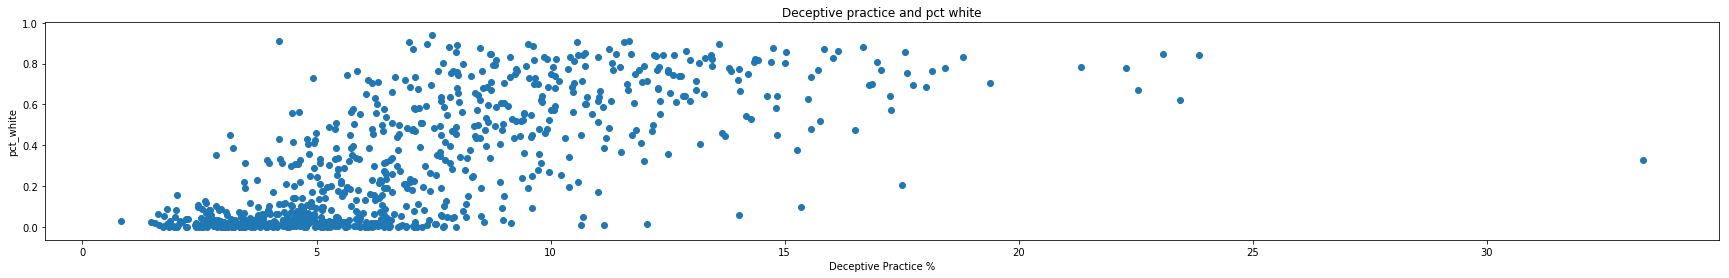

In [259]:
fig, ax = plt.subplots()
x = counts_pcts_census['Deceptive Practice Pct']
y = counts_pcts_census['pct_white']
ax.set(xlabel='Deceptive Practice %', ylabel='pct_white',
       title="Deceptive practice and pct white")
plt.scatter(x, y)
plt.show()

Tracts with a higher percentage of white residents also tend to have deceptive practice as a higher percentage of their crimes.

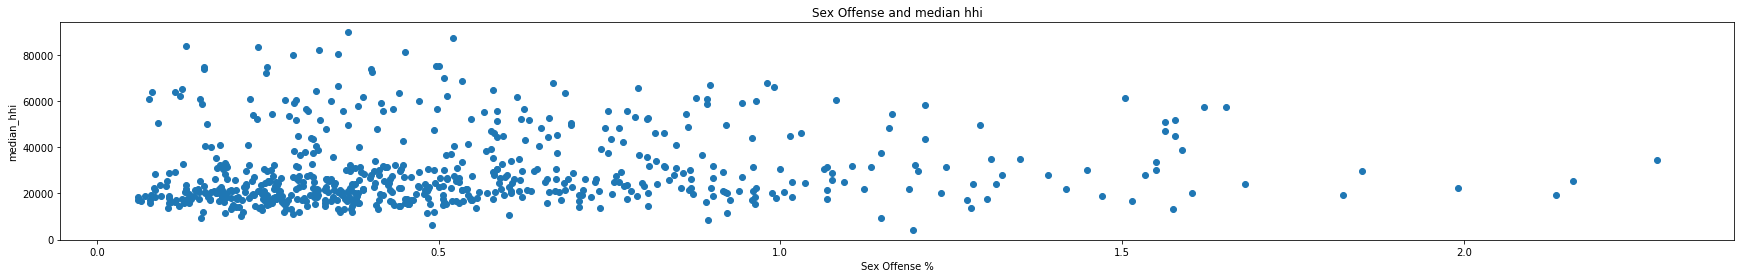

In [260]:
fig, ax = plt.subplots()
x = counts_pcts_census['Sex Offense Pct'].loc[counts_pcts_census.median_hhi > 0]
y = counts_pcts_census['median_hhi'].loc[counts_pcts_census.median_hhi > 0]
ax.set(xlabel='Sex Offense %', ylabel='median_hhi',
       title="Sex Offense and median hhi")
plt.scatter(x, y)
plt.show()

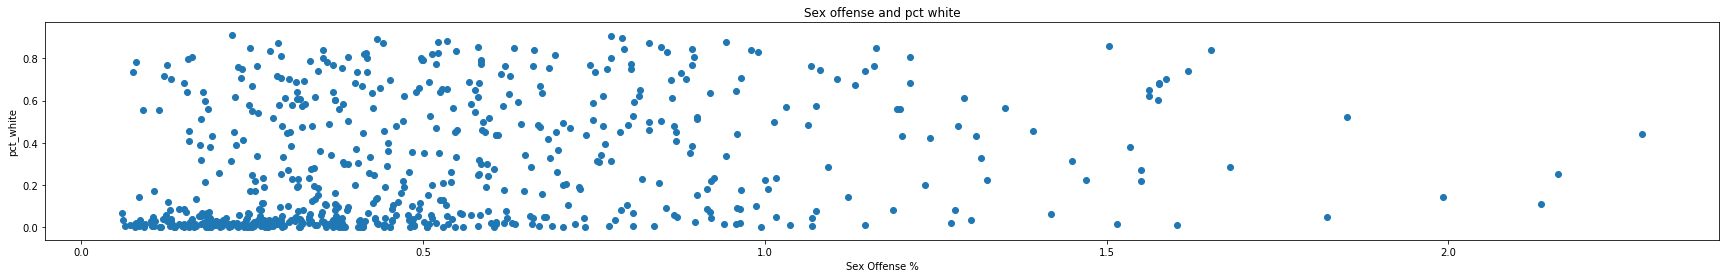

In [261]:
fig, ax = plt.subplots()
x = counts_pcts_census['Sex Offense Pct']
y = counts_pcts_census['pct_white']
ax.set(xlabel='Sex Offense %', ylabel='pct_white',
       title="Sex offense and pct white")
plt.scatter(x, y)
plt.show()

There is no clear correlation between median household income and percent white with sex offense as a percentage of crimes.

# Problem 3: Analysis and Communication

#### Based on the data you have from 1 and 2:

1. Describe how crime has changed in Chicago from 2017 to 2018

In [262]:
def annual_trend(field, df, count=True, graph=True):
    if count:
        data = pd.DataFrame(df.groupby([field, 'year']).size(), columns=['crime_count'])
    else:
        data = pd.DataFrame(df.groupby([field, 'year']).size() / df.groupby('year').size(), columns=['crime_pct'])
    data = data.unstack()
    data.columns=['output_2017', 'output_2018']
    
    if graph:
        try:
            N = len(df[field].unique())
            list_2017 = data.output_2017.tolist()
            list_2018 = data.output_2018.tolist()
            ind = np.arange(N) 
            width = 0.35       
            plt.bar(ind, list_2017, width, label='2017')
            plt.bar(ind + width, list_2018, width,
                label='2018')
            if count:
                plt.ylabel("Count of crimes")
            else:
                plt.ylabel("Percent of crimes")
            plt.title('Crimes by ' + field + ' and year')
            plt.xticks(ind + width / 2, (df[field].unique()))
            plt.legend(loc='best')
            plt.show()
        except:
            pass
        
    return data

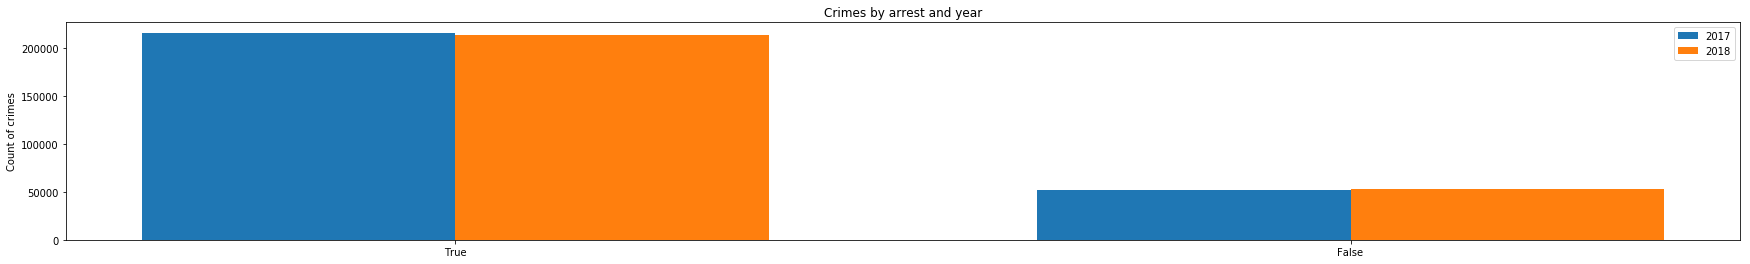

,output_2017,output_2018
arrest,,
False,215749,213658
True,52347,52620


In [263]:
annual_trend('arrest', crime_df)

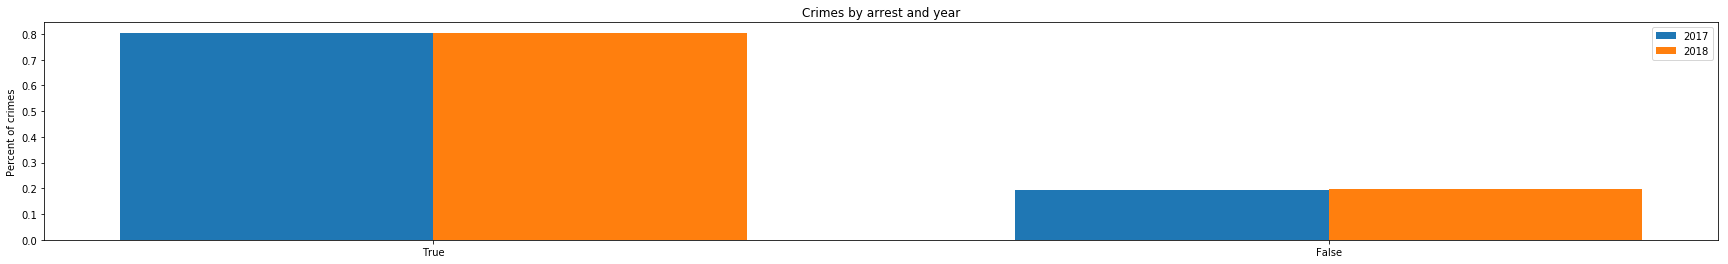

,output_2017,output_2018
arrest,,
False,0.804745,0.802387
True,0.195255,0.197613


In [264]:
annual_trend('arrest', crime_df, count=False)

There was no significant change in the proportion of crimes leading to an arrest.

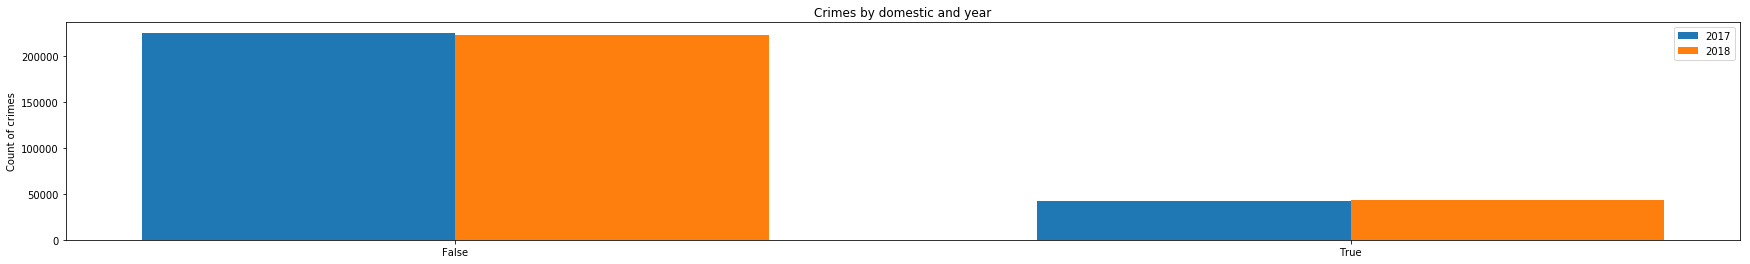

,output_2017,output_2018
domestic,,
False,225467,222632
True,42629,43646


In [265]:
annual_trend('domestic', crime_df)

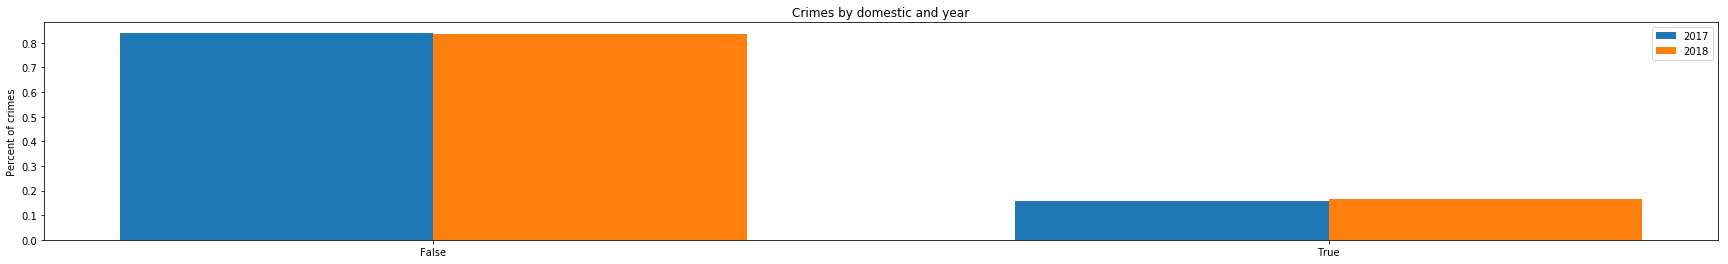

,output_2017,output_2018
domestic,,
False,0.840994,0.836089
True,0.159006,0.163911


In [266]:
annual_trend('domestic', crime_df, count=False)

In 2018, the number and percentage of domestic crimes increased.

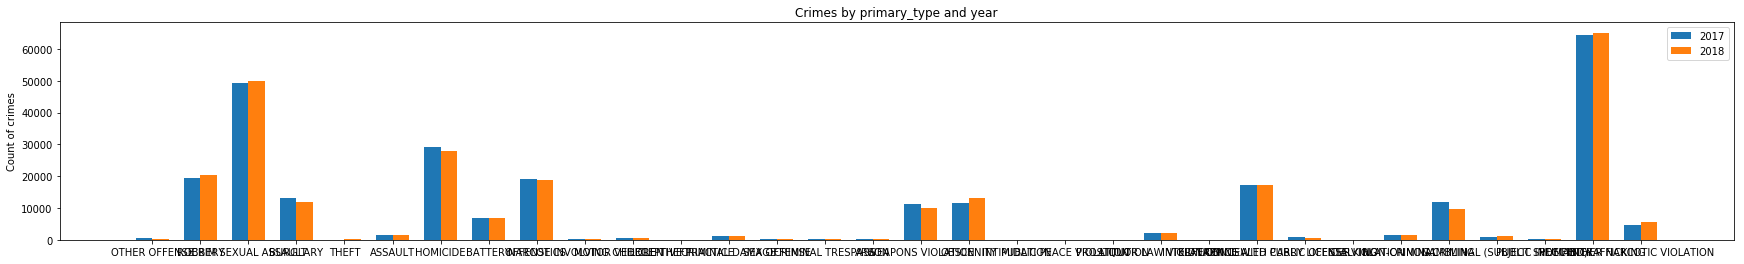

,output_2017,output_2018
primary_type,,
ARSON,444,372
ASSAULT,19303,20377
BATTERY,49214,49781
BURGLARY,13000,11730
CONCEALED CARRY LICENSE VIOLATION,69,149
CRIM SEXUAL ASSAULT,1628,1628
CRIMINAL DAMAGE,29042,27806
CRIMINAL TRESPASS,6812,6904
DECEPTIVE PRACTICE,19028,18736


In [267]:
annual_trend('primary_type', crime_df)

There were some shifts in the number of crimes by type. For example, burglary, criminal damage, deceptive practice, motor vehicle theft, and robberies went down. However, assault, interference with public officer, narcotics, theft, and weapons violations went up.

,output_2017,output_2018
district,,
001,15387,15609
002,11585,11814
003,12656,12047
004,14710,14124
005,11728,11905
006,16522,16409
007,13804,14211
008,16525,16285
009,11739,10984


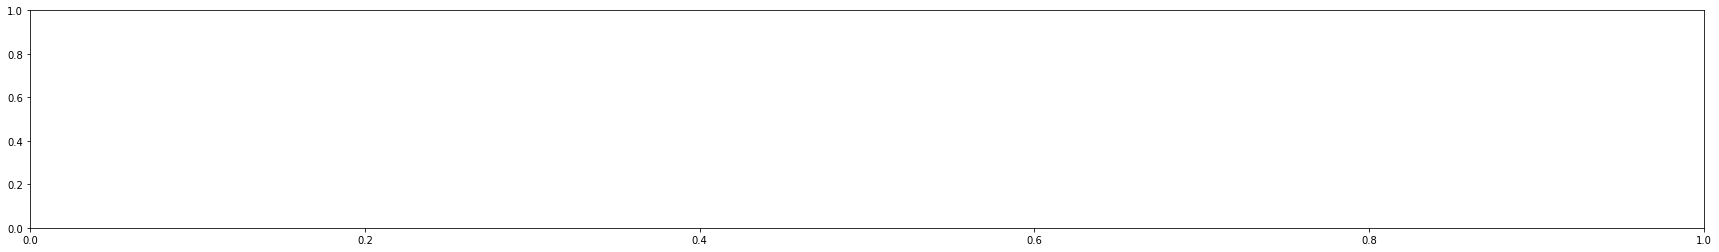

In [268]:
annual_trend('district', crime_df)

,output_2017,output_2018
district,,
001,0.057394,0.058619
002,0.043212,0.044367
003,0.047207,0.045242
004,0.054868,0.053042
005,0.043746,0.044709
006,0.061627,0.061624
007,0.051489,0.053369
008,0.061638,0.061158
009,0.043787,0.041250


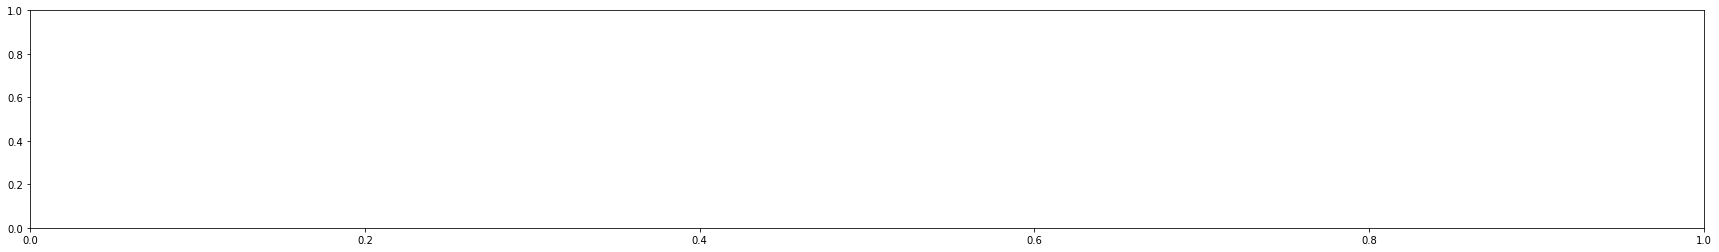

In [269]:
annual_trend('district', crime_df, count=False)

The proportion and number of crimes by district remained relatively stable, though it is worth noting there is a significant disparity in the concentration of crimes by district.

2. One of the alderman candidates from recent elections has some crime statistics on his website: https://www.ringer4results.com/node/8
Specifically:
Crime is a major issue in our neighborhoods over the last four years, and
the data shows just that.
Let’s break down the Chicago Police Department’s report for the month
leading up to July 26, 2018, compared to the same week in 2017:
• Robberies -- up 21 percent over the same time-frame in 2017
• Aggravated batteries -- up 136 percent
• Burglaries -- an increase of 50 percent
• Motor vehicle theft -- up 41 percent.
All told, crime rose 16 percent in the same 28-day time period in just one
year. But take a look at the year-to-date number and you’ll see how crime
has affected our local neighborhoods in a four-year period:
• Rose 10 percent since 2017
• Rose 22 percent since 2016

A. Are these statistics correct?
B. Could they be misleading or would you agree with the conclusions he’s
drawing? Why or why not?

In [270]:
crime_df['month_day'] = crime_df.date.map(lambda x: x.strftime('%m-%d'))

In [271]:
time_frame = crime_df.loc[
    ((crime_df['date'] > datetime.strptime('2017-06-26', '%Y-%m-%d')) &
    (crime_df['date'] <= datetime.strptime('2017-07-26', '%Y-%m-%d'))) |
    ((crime_df['date'] > datetime.strptime('2018-06-26', '%Y-%m-%d')) &
    (crime_df['date'] <= datetime.strptime('2018-07-26', '%Y-%m-%d')))]

In [272]:
ward_43 = annual_trend('primary_type', time_frame.loc[time_frame.ward == '43'], graph=False)
ward_43['pct_change'] = ward_43.apply(lambda x: (x['output_2018'] - x['output_2017']) / x['output_2017'], axis=1)
ward_43

,output_2017,output_2018,pct_change
primary_type,,,
ASSAULT,5.0,16.0,2.200000
BATTERY,38.0,35.0,-0.078947
BURGLARY,16.0,13.0,-0.187500
CRIM SEXUAL ASSAULT,3.0,1.0,-0.666667
CRIMINAL DAMAGE,32.0,31.0,-0.031250
CRIMINAL TRESPASS,6.0,16.0,1.666667
DECEPTIVE PRACTICE,32.0,40.0,0.250000
INTERFERENCE WITH PUBLIC OFFICER,1.0,NaN,NaN
KIDNAPPING,2.0,NaN,NaN


According to my output, robberies decreased by 35%, battery decreased by 7%, burglaries decreased by 19%, and motor vehicle theft increased 100%. These all conflict with reported results.

In [273]:
time_frame.loc[time_frame.ward == '43'].groupby('year').size()

year
2017    363
2018    403
dtype: int64

Crime in the 43rd ward went from 363 to 403 in the month prior to July 26 from 2017 to 2018. The report is correct in saying that this is a 10% increase.

3. As you know, there will be a new mayor in Chicago very soon. Based on these summary statistics, provide 5 key findings to the new mayor’s office about crime in Chicago and what they should focus on in order to deal with crime in Chicago.

-Austin is the most high-crime community area followed by the Near North Side. These two community areas have very different types of crime. Crimes in Austin are largely driven by theft, so policing efforts in Austin should specifically tackle theft. Crimes in Near North are more likely to involve battery or criminal damage.
-Overall, theft accounts for 24% of crimes and is the most common type to occur. Per the previous finding, it is also concentrated in specific neighborhoods.
-Low income areas and non-white areas tend to have more battery and homicide crimes. Policing efforts in these areas should focus on these crimes.
-Wealthy, white areas tend to have more deceptive practice crimes. Policing efforts in these areas should focus on deceptive practice.
-Domestic crimes have increased slightly from 2017 to 2018. Crime prevention efforts should evolve to focus more on preventing domestic crimes.

4. What are some of the key caveats of your recommendations and limitations of the analysis that you just did?

My analysis examines many correlations, but they make no claims about causation, so increasing incomes in a neighborhood with high rates of homicides will not necessarily decrease homicides. Furthermore, the demographic data I obtained is only based on a single year whereas the crime data was based on two years. Therefore, we can only see how crime varies with demographics by location and not how crime varies with demographics over time.

# Problem 4: Assume you are running the 911 call center for Chicago. You get a call from someone at 2111 S Michigan Ave

A. Of the types of crimes you have data for, which crime type is the most likely given the call came from 2111 S Michigan Ave? What are the probabilities for each type of request?

In [274]:
part_a = pd.DataFrame(
    crime_df.loc[crime_df.block == "021XX S MICHIGAN AVE"].groupby(by='primary_type').size(), columns=['counts'])
part_a['percents'] = part_a.apply(lambda x: x['counts'] / part_a.counts.sum(), axis=1)
part_a

,counts,percents
primary_type,,
ASSAULT,6,0.100000
BATTERY,16,0.266667
BURGLARY,1,0.016667
CRIMINAL DAMAGE,6,0.100000
CRIMINAL TRESPASS,1,0.016667
DECEPTIVE PRACTICE,6,0.100000
MOTOR VEHICLE THEFT,2,0.033333
OTHER OFFENSE,13,0.216667
PUBLIC PEACE VIOLATION,1,0.016667


Battery is the most likely type of crime to come from 2111 S Michigan Ave. 
The probabilities for each type of request are shown in the percents column above.

B. Let’s now assume that a call comes in about Theft. Which is more likely – that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?

In [275]:
theft_counts = pd.DataFrame(
    crime_df.loc[crime_df.primary_type == 'THEFT'].groupby(by='community_area').size(), columns=['counts'])
theft_counts['percents'] = theft_counts.apply(lambda x: x['counts'] / theft_counts.counts.sum(), axis=1)
theft_counts

,counts,percents
community_area,,
1,2282,0.017631
10,571,0.004412
11,555,0.004288
12,313,0.002418
13,628,0.004852
14,1251,0.009666
15,1601,0.012370
16,1587,0.012262
17,589,0.004551


In [276]:
theft_counts.loc['26']

counts      1213.000000
percents       0.009372
Name: 26, dtype: float64

In [277]:
theft_counts.loc['27']

counts      1281.000000
percents       0.009897
Name: 27, dtype: float64

In [278]:
theft_counts.loc['3']

counts      1954.000000
percents       0.015097
Name: 3, dtype: float64

For theft from 2017-2018, 1213 crimes were in West Garfield Park, 1281 crimes were in East Garfield Park, and 1954 crimes were in Uptown. Crimes are more likely to come from Garfield Park as a whole. About 1.9% of thefts happen in Garfield Park and about 1.5% of thefts happen in Uptown, so thefts are about 0.4 percentage points more likely to come from Garfield Park.

C. Now assume that you don’t have access to all the raw data and you know the following things: There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of the 600 calls from Garfield Park, 100 of them are about Battery. Of the 400 calls from Uptown, 160 are about Battery. If a call comes about Battery, how much more/less likely is it that the call came from Garfield Park versus Uptown?

This means 160 Battery calls came from Uptown and 100 Battery calls came from Garfield Park, for a total of 260 Battery calls. This means 61.5% of Battery calls came from Uptown and 38.5% of Battery calls came from Garfield Park. Therefore, Battery calls are about 23 percentage points more likely to come from Uptown.